In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,72742,None,None,86085.715275
2020-06-13,72743,None,None,79940.811469
2020-06-14,72744,None,None,74244.112992
2020-06-15,72745,None,None,68878.187593
2020-06-16,72746,None,None,64137.552455
...,...,...,...,...
2021-06-23,73118,None,None,244168.061048
2021-06-24,73119,None,None,252188.694466
2021-06-25,73120,None,None,260099.055394


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-27_2021-06-27-19-48.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-26_2021-06-26-18-41.pickle


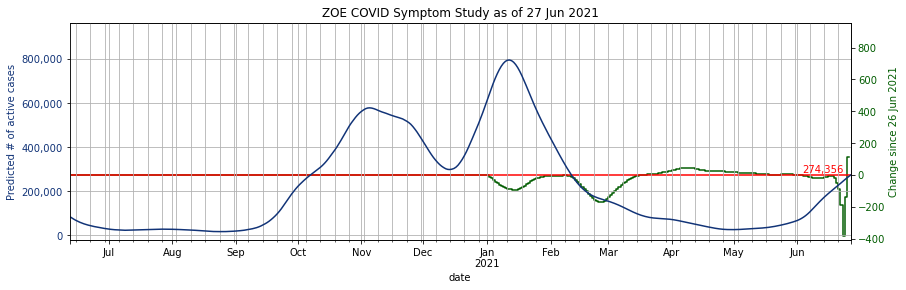

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

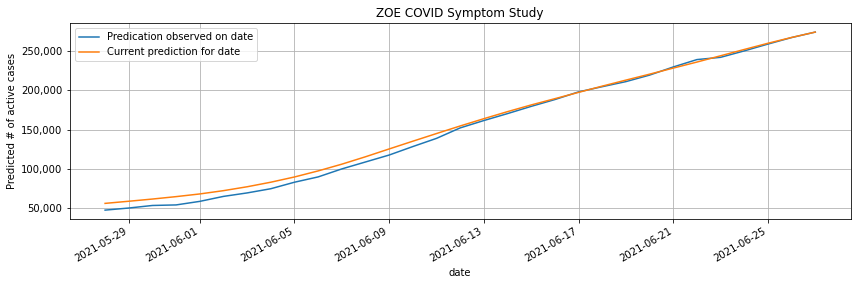

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-06-27_2021-06-27-19-48.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
390,Dundee City,S12000042,3.017534
276,Liverpool,E08000012,2.353336
313,Aberdeen City,S12000033,2.273637
325,Glasgow City,S12000046,2.086336
268,Oldham,E08000004,1.725052
164,Chorley,E07000118,1.495184
235,Manchester,E08000003,1.379162
270,Salford,E08000006,1.276101
171,Preston,E07000123,1.252578
287,Birmingham,E08000025,1.241367
